In [232]:
import os, glob
import pandas as pd
from tqdm import tqdm
from collections import defaultdict, Counter
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
%matplotlib inline

sns.set_theme ()

### What is the distribution of mobile characters?

For each book, let's create a list of characters that have at least two distinct locations

In [138]:
def get_char_location_history (frame):
    corefs = dict ()
    char_locations = dict ()
    for _,row in frame.iterrows ():
        char_name = row["persons_text"].lower()
        loc_name = row["locations_text"].lower()
        per_coref = row["persons_coref"]
        if per_coref not in corefs:
            corefs[per_coref] = set ()
        corefs[per_coref].add (char_name)
        if per_coref not in char_locations:
            char_locations[per_coref] = list ()
        char_locations[per_coref].append (loc_name)
    
    return corefs, char_locations

In [139]:
book_mobile_chars = dict ()
dirname = "/mnt/data0/ssoni/projects/books-mobility/data"
for filename in tqdm(glob.glob (os.path.join (dirname, "*.collocations"))):
    book_id = os.path.basename (filename).split (".")[0]
    df = pd.read_csv (filename, sep="\t")
    corefs, char_locations = get_char_location_history (df)
    mobile_chars = {ref_name: len(set(char_locations[ref_name])) for ref_name in char_locations}
    book_mobile_chars[book_id] = mobile_chars
    #print (filename, len (df))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12998/12998 [01:23<00:00, 155.43it/s]


In [140]:
most_mobile_distribution = defaultdict (int)
for book in book_mobile_chars:
    max_val = max(list(book_mobile_chars[book].values()), default=0)
    most_mobile_distribution[max_val] += 1

Text(0.5, 1.0, 'Distribution of mobile characters in our collection')

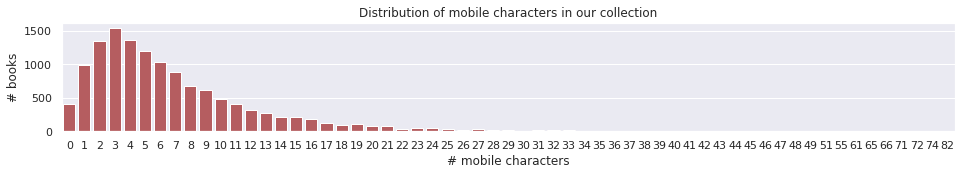

In [141]:
sns.set_style("darkgrid")
#sns.color_palette("Blues", as_cmap=True)
fig, ax = plt.subplots(figsize=(16,2))
sns.barplot(ax=ax, x="chars", y="books", 
            data=pd.DataFrame.from_records (list(most_mobile_distribution.items()), columns=['chars', 'books']),
            color="r")
ax.set_ylabel ("# books")
ax.set_xlabel ("# mobile characters")
ax.set_title ("Distribution of mobile characters in our collection")
#plt.xticks(rotation=70)

### Where are the characters before and where do they move?

In [148]:
moved_from_to = dict ()
dirname = "/mnt/data0/ssoni/projects/books-mobility/data"
for filename in tqdm(glob.glob (os.path.join (dirname, "*.collocations"))):
    book_id = os.path.basename (filename).split (".")[0]
    df = pd.read_csv (filename, sep="\t")
    df = df.sort_values (by="locations_start_token")
    corefs, char_locations = get_char_location_history (df)
    char_locations = {ref_name: char_locations[ref_name] for ref_name in char_locations if len (set (char_locations[ref_name])) == 2}
    moved_from_to[book_id] = char_locations

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12998/12998 [01:05<00:00, 199.36it/s]


In [161]:
mobility_dyads = defaultdict (int)
for book in moved_from_to:
    for char in moved_from_to[book]:
        places = moved_from_to[book][char]
        if len(places) == 2:
            mobility_dyads[(places[0], places[1])] += 1
        else:
            pl = list (set (places))
            x = places.index (pl[0])
            y = places.index (pl[1])
            if x < y:
                mobility_dyads[(pl[0], pl[1])] += 1
            else:
                mobility_dyads[(pl[1], pl[0])] += 1
                                
moving_from = Counter ()
moved_to = Counter ()

for src, tgt in mobility_dyads:
    moving_from[src] += 1
    moved_to[tgt] += 1

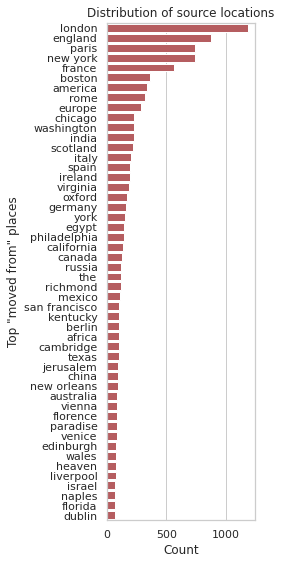

In [190]:
sns.set_style ('whitegrid')
fig, ax = plt.subplots(figsize=(4,8))
x,y = list (zip (*moving_from.most_common (50)))
series = [[x[i]]*y[i] for i, item in enumerate (x)]
series = [item for nested_item in series for item in nested_item]
sns.countplot (ax=ax, y="places", color='r', data=pd.DataFrame (series, columns=["places"]))
ax.set_ylabel ('Top "moved from" places')
ax.set_xlabel ('Count')
ax.set_title ('Distribution of source locations')
fig.tight_layout()

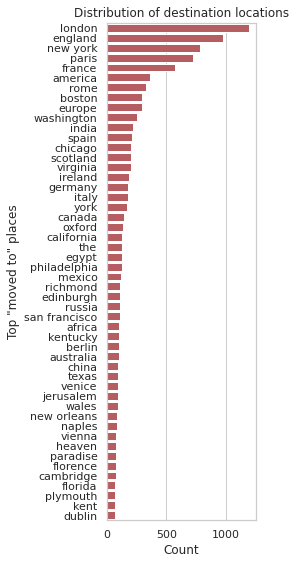

In [191]:
sns.set_style ('whitegrid')
fig, ax = plt.subplots(figsize=(4,8))
x,y = list (zip (*moved_to.most_common (50)))
series = [[x[i]]*y[i] for i, item in enumerate (x)]
series = [item for nested_item in series for item in nested_item]
sns.countplot (ax=ax, y="places", color='r', data=pd.DataFrame (series, columns=["places"]))
ax.set_ylabel ('Top "moved to" places')
ax.set_xlabel ('Count')
ax.set_title ('Distribution of destination locations')
fig.tight_layout()

In [193]:
flights = sns.load_dataset("flights")
flights = flights.pivot("month", "year", "passengers")
flights

year,1949,1950,1951,1952,1953,1954,1955,1956,1957,1958,1959,1960
month,,,,,,,,,,,,
Jan,112,115,145,171,196,204,242,284,315,340,360,417
Feb,118,126,150,180,196,188,233,277,301,318,342,391
Mar,132,141,178,193,236,235,267,317,356,362,406,419
Apr,129,135,163,181,235,227,269,313,348,348,396,461
May,121,125,172,183,229,234,270,318,355,363,420,472
Jun,135,149,178,218,243,264,315,374,422,435,472,535
Jul,148,170,199,230,264,302,364,413,465,491,548,622
Aug,148,170,199,242,272,293,347,405,467,505,559,606
Sep,136,158,184,209,237,259,312,355,404,404,463,508


<AxesSubplot:xlabel='destination', ylabel='source'>

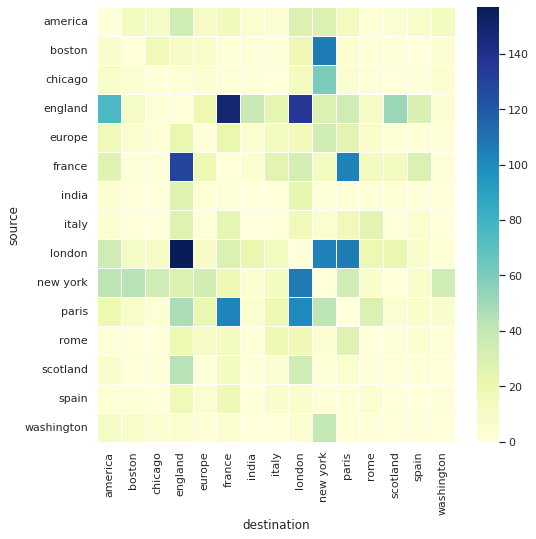

In [198]:
k=15
union = set ([p for p,_ in moving_from.most_common (k)]) or set ([p for p,_ in moved_to.most_common (k)])
rows = [[src, dst, mobility_dyads[(src,dst)]] for src in union for dst in union]
dyads = pd.DataFrame (rows, columns=["source", "destination", "dyads"])
dyads = dyads.pivot ("source", "destination", "dyads")

fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap (ax=ax, data=dyads, cmap="YlGnBu", linewidths=.5)

### When in the story time do the characters move?

In [213]:
dirname = "/mnt/data0/ssoni/projects/books-mobility/data"
datadir = "/mnt/data0/kentkchang/charemotions/corpus/booknlp.1.0.7/gutenberg_fiction_tagged_1_4"
num_partitions = 10
mobility_dist = dict ()
for filename in tqdm(glob.glob (os.path.join (dirname, "*.collocations"))):
    book_id = os.path.basename (filename).split (".")[0]
    df = pd.read_csv (filename, sep="\t")
    df = df.sort_values (by="locations_start_token")
    #tokens = pd.read_csv (os.path.join (datadir, f"{book_id}.tokens"), sep="\t", engine="python", on_bad_lines='skip')
    num_tokens = 0
    with open (os.path.join (datadir, f"{book_id}.tokens")) as fin:
        num_tokens = len([l for l in fin])
    #num_tokens = tokens["token_ID_within_document"].max() + 1
    decile_dist = dict ()
    for i in range (num_partitions):
        df_part = df[df["locations_start_token"] <= (i+1) * .1 * num_tokens]
        corefs, char_locations = get_char_location_history (df_part)
        num_mobile = len([char for char in char_locations if len(set(char_locations[char])) >= 2])
        decile_dist[i] = num_mobile
    if decile_dist[num_partitions-1] > 0:
        mobility_dist[book_id] = {i: decile_dist[i]/decile_dist[num_partitions-1] for i in range (num_partitions)}

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12998/12998 [18:26<00:00, 11.75it/s]


Text(0.5, 1.0, 'Mobility as a function of reading time')

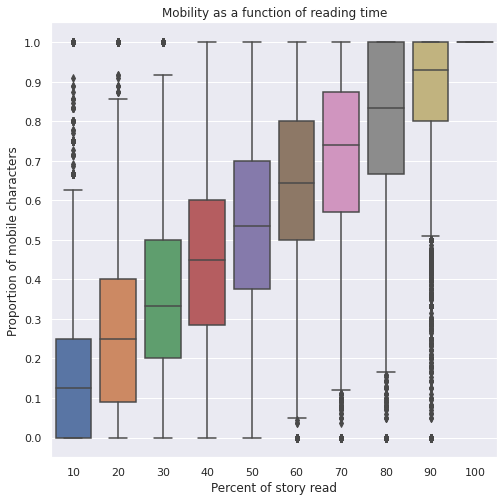

In [234]:
sns.set_style ('darkgrid')
fig, ax = plt.subplots(figsize=(8,8))
rows = list ()
for book in mobility_dist:
    for decile in mobility_dist[book]:
        rows.append([decile, mobility_dist[book][decile]])
        
mobility_of_chars = pd.DataFrame (rows, columns=["deciles", "characters"])
sns.boxplot (ax=ax, data=mobility_of_chars, x="deciles", y="characters")
#ax.grid(b=True, which='major', color='w', linewidth=1.0)
#ax.grid(b=True, which='minor', color='w', linewidth=0.5)
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
ax.set_xlabel ("Percent of story read")
ax.set_ylabel ("Proportion of mobile characters")
ax.set_xticklabels([f"{10*i}" for i in range (1, 10+1)])
ax.set_title("Mobility as a function of reading time")

In [215]:
mobility_dist

{'18520': {0: 0.0,
  1: 0.0,
  2: 0.0,
  3: 0.42857142857142855,
  4: 0.42857142857142855,
  5: 0.42857142857142855,
  6: 0.42857142857142855,
  7: 0.5714285714285714,
  8: 0.8571428571428571,
  9: 1.0},
 '33597': {0: 0.058823529411764705,
  1: 0.058823529411764705,
  2: 0.23529411764705882,
  3: 0.29411764705882354,
  4: 0.5882352941176471,
  5: 0.8235294117647058,
  6: 0.8235294117647058,
  7: 0.8823529411764706,
  8: 0.8823529411764706,
  9: 1.0},
 '34419': {0: 0.0,
  1: 0.1,
  2: 0.2,
  3: 0.5,
  4: 0.6,
  5: 0.6,
  6: 0.6,
  7: 0.8,
  8: 0.9,
  9: 1.0},
 '23791': {0: 0.0,
  1: 0.0,
  2: 1.0,
  3: 1.0,
  4: 1.0,
  5: 1.0,
  6: 1.0,
  7: 1.0,
  8: 1.0,
  9: 1.0},
 '38719': {0: 0.375,
  1: 0.625,
  2: 0.625,
  3: 0.75,
  4: 0.75,
  5: 0.75,
  6: 0.875,
  7: 0.875,
  8: 0.875,
  9: 1.0},
 '46117': {0: 0.058823529411764705,
  1: 0.058823529411764705,
  2: 0.29411764705882354,
  3: 0.5294117647058824,
  4: 0.5294117647058824,
  5: 0.8235294117647058,
  6: 0.8823529411764706,
  7: 0.9411